In [98]:
# Import dependecies
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms


In [12]:
torch.__version__

'1.3.1'

In [44]:
# Load data
transform_ds = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.FashionMNIST(root="data", train=True, transform=transform_ds)
test_ds = datasets.FashionMNIST(root="data", train=False, transform=transform_ds)


In [50]:
np.unique(train_ds.targets.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

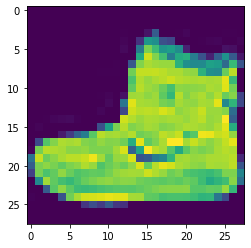

In [45]:
# Show image for sense
plt.imshow(train_ds.data[0])

In [70]:
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)


In [89]:
class CnnClassifier(nn.Module):
    
    def __init__(self):
        super(CnnClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.drop = nn.Dropout2d(p=0.05)
        self.linear1 = nn.Linear(11*11*16, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 8x26x26
        x = self.pool1(x)  # 8x13x13
        x = self.drop(x)
        x = F.relu(self.conv2(x))  # 32x11x11
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CnnClassifier().to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    

In [90]:
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = criterion(output, targets)
        train_loss += loss.item()
        train_acc += sum(torch.argmax(output, dim=1) == targets).item()
        loss.backward()
        optimizer.step()
    else:
        train_loss /= len(train_ds)
        train_acc /= len(train_ds)
    
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model.forward(inputs)
            loss = criterion(output, targets)
            test_loss += loss.item()
            test_acc += sum(torch.argmax(output, dim=1) == targets).item()
        else:
            test_loss /= len(test_ds)
            test_acc /= len(test_ds)
    
    print(f"Epoch {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc * 100:.2f} | "
          f"Test loss: {test_loss:.4f} | Test acc: {test_acc * 100:.2f}")    


Epoch 1 | Train loss: 0.9951 | Train acc: 62.22 | Test loss: 0.7965 | Test acc: 69.42
Epoch 2 | Train loss: 0.7625 | Train acc: 70.44 | Test loss: 0.7560 | Test acc: 70.23
Epoch 3 | Train loss: 0.7183 | Train acc: 71.78 | Test loss: 0.7332 | Test acc: 71.45
Epoch 4 | Train loss: 0.6881 | Train acc: 72.69 | Test loss: 0.7094 | Test acc: 72.10
Epoch 5 | Train loss: 0.6642 | Train acc: 73.35 | Test loss: 0.7024 | Test acc: 72.09


In [91]:
# Get confusion matrix
def plot_confusion_matrix(y_pred, y_actual, figsize=(10, 8)):
    """Plot confusion matrix.
    """
    cm = confusion_matrix(y_pred, y_actual)
    cm_norm = cm
    #cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_norm, interpolation='none', cmap='seismic', aspect='equal')
    ax.figure.colorbar(im, ax=ax, shrink=0.85)
    ax.set_title('Confusion matrix', fontsize=14)
    tick_marks = np.arange(10)
    #tick_marks = np.arange(len(encoder.categories_[0]))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    #ax.set_xticklabels(encoder.categories_[0], rotation=90)
    #ax.set_yticklabels(encoder.categories_[0])

    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        if cm_norm[i, j]!=0:
            ax.text(j, i, 
                    format(cm_norm[i, j], '.0f'),
                    horizontalalignment='center', verticalalignment='center', 
                    color='black' if (0.35 < cm_norm[i, j] < 0.65) else 'white',
                    fontsize=10,
                    fontweight=700)

    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('Actual label', fontsize=14)
    ax.grid(linestyle=':')

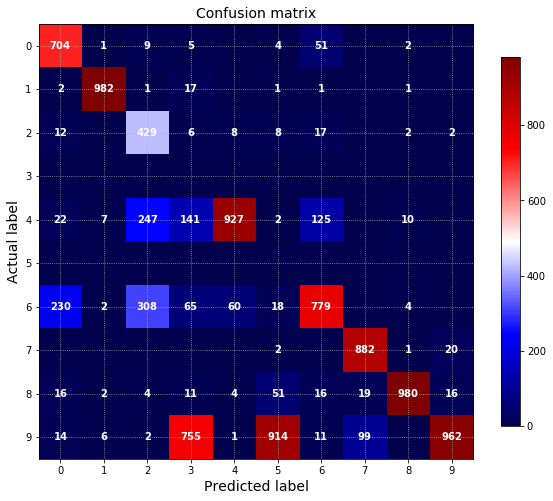

In [99]:
model.eval()
device_cpu = torch.device("cpu")
N = 100000
result2 = torch.argmax(model.to(device_cpu).forward(test_ds.data[:N].unsqueeze(1).to(device_cpu).to(torch.float)), dim=1).tolist()
plot_confusion_matrix(result2, test_ds.targets[:N].tolist())
